For this project, I chose to perform a new type of music that is both catch and emotionally provoking. Recurrent Neural Networks were used for this generative task to predict the next element in the sequence given the previous elements. FluidSynth & pretty_midi libraries were installed. FluidSynth serves as a real-time software synthesizer designed to produce music and sound. It enables the playback of MIDI files or the dynamic generation of music through the use of programmatically controlled MIDI events.

Pretty_midi, serves as a versatile tool designed for the manipulation of MIDI (Musical Instrument Digital Interface) files. MIDI files, being a standardized protocol, are used for the digital representation of musical information.

https://www.tensorflow.org/tutorials/audio/music_generation

In [54]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [55]:
!pip install --upgrade pyfluidsynth

In [56]:
!pip install pretty_midi

In [57]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [58]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Downloading the Maestro dataset

In [59]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [60]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

use pretty_midi library to parse a single MIDI file and examine the structure of the notes within it.

In [61]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_04_R1_2015_wav--3.midi



Create a PrettyMIDI object corresponding to the provided sample MIDI file.

In [62]:
pm = pretty_midi.PrettyMIDI(sample_file)


Function that takes a PrettyMIDI object (pm) as input and generates an audio waveform from it using the FluidSynth synthesizer

In [63]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [64]:
display_audio(pm)

In [65]:
# number of instruments in the audio
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [66]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=72, note_name=C5, duration=0.5521
1: pitch=75, note_name=D#5, duration=0.1375
2: pitch=74, note_name=D5, duration=0.3719
3: pitch=74, note_name=D5, duration=0.0948
4: pitch=34, note_name=A#1, duration=1.0812
5: pitch=75, note_name=D#5, duration=0.0656
6: pitch=46, note_name=A#2, duration=0.1385
7: pitch=74, note_name=D5, duration=0.0615
8: pitch=75, note_name=D#5, duration=0.0625
9: pitch=74, note_name=D5, duration=0.0615


The function accepts the file path of a MIDI file as an input parameter and produces a pandas DataFrame that encapsulates details regarding the notes present in the specified MIDI file.

In [67]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [68]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,34,0.982292,2.063542,0.000000,1.081250
1,72,0.992708,1.544792,0.010417,0.552083
2,74,1.503125,1.875000,0.510417,0.371875
3,75,1.705208,1.842708,0.202083,0.137500
4,74,1.875000,1.969792,0.169792,0.094792


converting pitch from the numeric values to note names.


In [69]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A#1', 'C5', 'D5', 'D#5', 'D5', 'A#2', 'D#5', 'D5', 'D#5', 'D5'],
      dtype='<U3')


Generate a visual representation of the musical composition by plotting the pitch, start time, and end time of the notes along the entire length of the track, resembling a piano roll. Begin by visualizing the information for the first 100 notes.

In [70]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

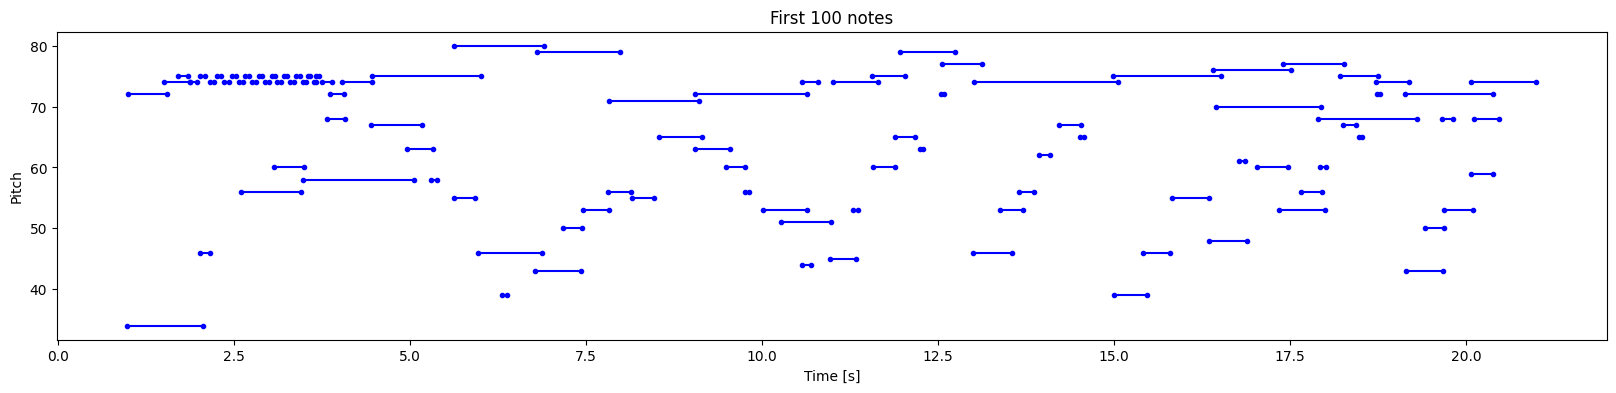

In [71]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

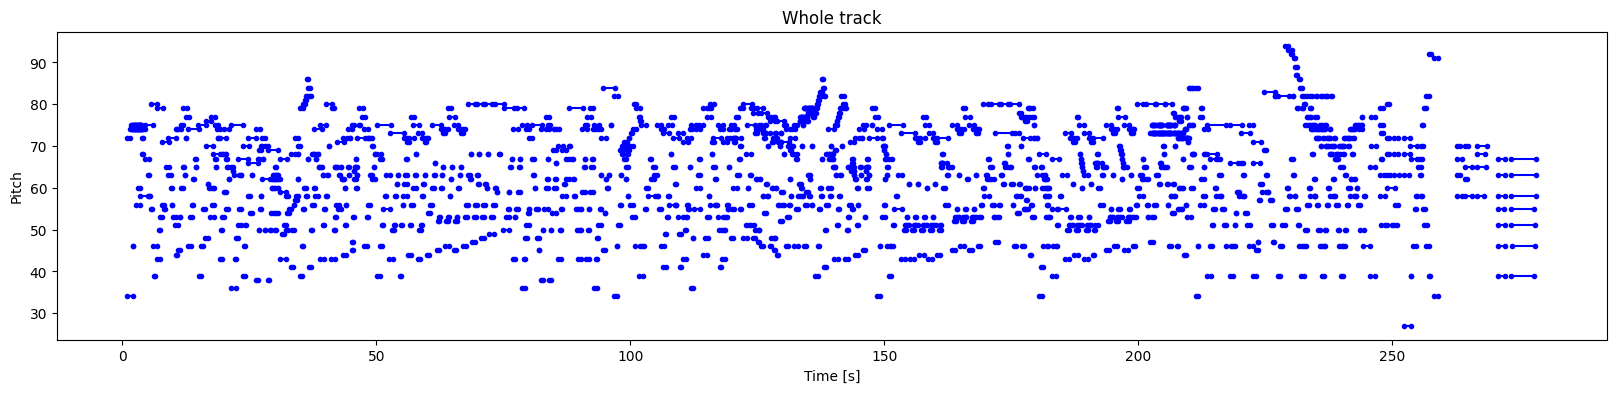

In [72]:
plot_piano_roll(raw_notes)

Function to create a MIDI file

In [73]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [74]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [75]:
display_audio(example_pm)

## Create the training dataset


In [76]:
num_files = 20
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [77]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 81403


Create tf.data.Dataset from the parsed notes.

In [78]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [79]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

The model will undergo training using batches of note sequences. Each instance will comprise a sequence of notes serving as input features, while the subsequent note will function as the corresponding label. This approach enables the model to learn the prediction of the next note within a given sequence.

In [80]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

The vocabulary size (vocab_size) is configured as 128, encompassing all the pitches supported by pretty_midi.
Sequence length is set to 50

In [81]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [82]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (50, 3)
sequence elements (first 10): tf.Tensor(
[[0.46875    0.         0.071875  ]
 [0.375      0.01145833 0.06458333]
 [0.5625     0.         0.09791667]
 [0.4921875  0.         0.10833333]
 [0.3984375  0.00520833 0.06979167]
 [0.4296875  0.         0.07708333]
 [0.5234375  0.         0.115625  ]
 [0.5234375  0.38854167 0.125     ]
 [0.5859375  0.090625   0.1625    ]
 [0.5625     0.20416667 0.09479167]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=71.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.328125>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.49270833333333375>}


Use batch size of 64, and configure the dataset for performance.

In [83]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [84]:
train_ds.element_spec

(TensorSpec(shape=(64, 50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Model Development and Training


The model is designed to produce three outputs, each corresponding to a different note variable. Specifically, for the step and duration variables, a custom loss function rooted in mean squared error will be employed. This custom loss function is structured to incentivize the model to generate non-negative values for these variables.

In [85]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [86]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 3)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 128)                  67584     ['input_2[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_1[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_1[0][0]']              
                                                                                            

Evaluate the model

In [42]:
losses = model.evaluate(train_ds, return_dict=True)
losses

1271/1271 [==============================] - 40s 4ms/step - loss: 5.2774 - duration_loss: 0.2044 - pitch_loss: 4.8560 - step_loss: 0.2170


{'loss': 5.2773823738098145,
 'duration_loss': 0.2043866217136383,
 'pitch_loss': 4.855980396270752,
 'step_loss': 0.21701973676681519}

step_loss and duration_loss are low. Pitch_loss is high, hence high total loss of 5.083

Compile the model

Adjusting loss weights and using a suitable optimizer.

In [43]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)


The overall loss is computed as the weighted sum of the individual losses.

In [44]:
model.evaluate(train_ds, return_dict=True)

1271/1271 [==============================] - 5s 3ms/step - loss: 0.6642 - duration_loss: 0.2044 - pitch_loss: 4.8560 - step_loss: 0.2170


{'loss': 0.6642059087753296,
 'duration_loss': 0.2043866217136383,
 'pitch_loss': 4.855980396270752,
 'step_loss': 0.21701973676681519}

Train the model.

In [45]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

Use Callbacks to stop when the model is at its optimal training


In [46]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
1271/1271 [==============================] - 14s 6ms/step - loss: 0.2971 - duration_loss: 0.0703 - pitch_loss: 4.0262 - step_loss: 0.0255
Epoch 2/50
1271/1271 [==============================] - 8s 7ms/step - loss: 0.2876 - duration_loss: 0.0676 - pitch_loss: 3.9100 - step_loss: 0.0245
Epoch 3/50
1271/1271 [==============================] - 8s 6ms/step - loss: 0.2820 - duration_loss: 0.0648 - pitch_loss: 3.8686 - step_loss: 0.0238
Epoch 4/50
1271/1271 [==============================] - 8s 6ms/step - loss: 0.2795 - duration_loss: 0.0635 - pitch_loss: 3.8538 - step_loss: 0.0233
Epoch 5/50
1271/1271 [==============================] - 10s 8ms/step - loss: 0.2767 - duration_loss: 0.0619 - pitch_loss: 3.8311 - step_loss: 0.0232
Epoch 6/50
1271/1271 [==============================] - 9s 7ms/step - loss: 0.2741 - duration_loss: 0.0609 - pitch_loss: 3.8060 - step_loss: 0.0230
Epoch 7/50
1271/1271 [==============================] - 9s 7ms/step - loss: 0.2707 - duration_loss: 0.0593 - p

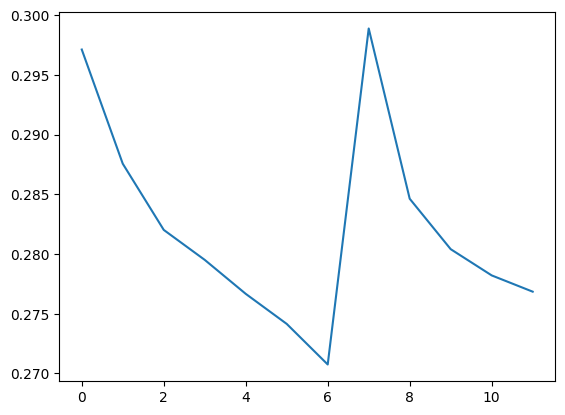

In [47]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()


Function to generate a predicted note based on a trained sequence model

In [48]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes setting temperature at 20, which can be changed to any number greater than 0.

In [49]:
temperature = 10
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 19ms/step


In [50]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,47,0.324902,0.580901,0.324902,0.905802
1,72,0.312518,0.611173,0.637420,1.248593
2,80,0.341889,0.612751,0.979308,1.592059
3,47,0.355715,0.618805,1.335023,1.953828
4,95,0.343949,0.610908,1.678972,2.289880
5,101,0.331405,0.602705,2.010377,2.613082
6,50,0.353107,0.616779,2.363484,2.980263
7,95,0.349287,0.614390,2.712771,3.327160
8,101,0.344877,0.611541,3.057648,3.669188
9,84,0.341776,0.609571,3.399424,4.008995


In [51]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [87]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualize the generated notes.

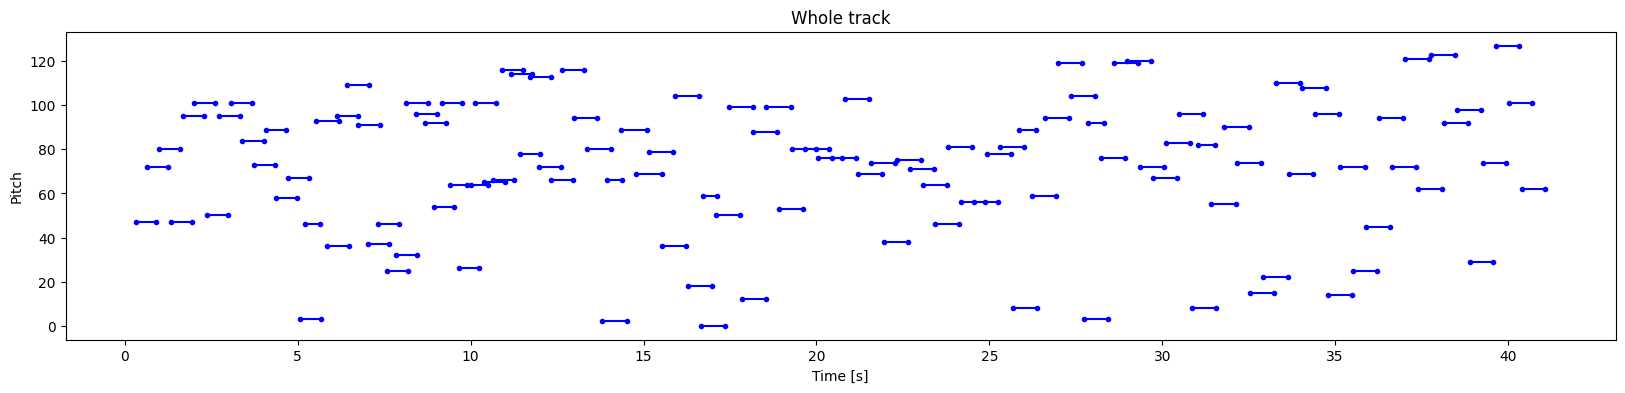

In [53]:
plot_piano_roll(generated_notes)